In [12]:
import os
import numpy as np
import scipy
import pandas as pd

import lmfit

from scipy.stats import norm, chi2 
from scipy.odr import ODR, Model, RealData

import matplotlib.pyplot as plt

## Harmonic Osciallator Fitting

In [80]:
def damped_osc(t, A, omega, gamma, phase, shift):
    omega_damped = np.sqrt(omega**2 - gamma**2)
    return A*np.cos(omega_damped*t+phase)*np.exp(-gamma*t) + shift  

def osc(t, A, omega, phase, shift):
    return A*np.cos(omega*t+phase) + shift

In [419]:
Length = "26.80"
df = pd.read_csv(Length + '.csv') 

In [420]:
df.keys()

Index(['Unnamed: 0', '質量 A', 'Unnamed: 2'], dtype='object')

In [421]:
ts = np.array([float(t) for t in df[df.keys()[0]][1:]])
xs = np.array([float(x) for x in df[df.keys()[1]][1:]])
xerr = 0.25/2*np.ones(xs.shape[0])

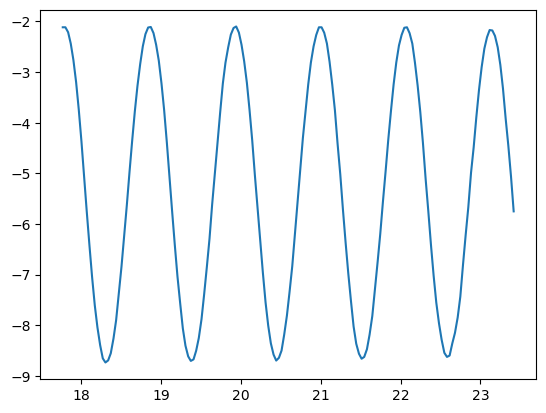

In [422]:
plt.plot(ts,xs)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 170
    # variables        = 4
    chi-square         = 39.3091330
    reduced chi-square = 0.23680201
    Akaike info crit   = -240.938064
    Bayesian info crit = -228.394870
    R-squared          = 0.99933303
[[Variables]]
    A:      3.29577555 +/- 0.00661088 (0.20%) (init = 4)
    omega:  5.87861671 +/- 0.00122165 (0.02%) (init = 5.654867)
    phase: -4.02187872 +/- 0.02528605 (0.63%) (init = 0)
    shift: -5.36748982 +/- 0.00468315 (0.09%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(omega, phase) = -0.9969


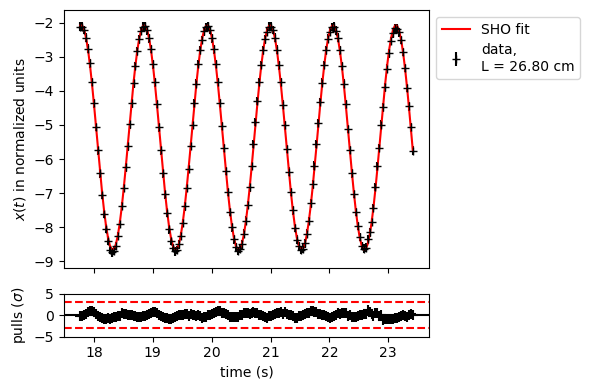

In [424]:
#### run fit
model = lmfit.Model(osc)

result = model.fit(t=ts, data = xs,  weights=1/xerr, A = 4, omega = 1.8*np.pi, phase = 0, shift = -6)

lmfit.report_fit(result)


####plotting
xs_fit = model.eval(result.params, t=ts)
pull = (xs-xs_fit)/(0.25/2)

# --- Create figure with 2 panels ---
fig, (ax_main, ax_pull) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={'height_ratios': [6, 1]},
    figsize=(6, 4)
)

# --- Top: data + fit ---
ax_main.errorbar(ts, xs, xerr, fmt='k+', label='data,\nL = '+ Length + ' cm')
ax_main.plot(ts, xs_fit, color='red', label= 'SHO' +' '+'fit')
ax_main.set_ylabel(r"$x(t)$ in normalized units")
ax_main.legend(loc="upper left", bbox_to_anchor=(1, 1))

# --- Bottom: pulls ---
ax_pull.scatter(ts, pull, color='black', marker="+", s=50)
ax_pull.axhline(0, color='black', linestyle='-')
ax_pull.axhline(3, color='red', linestyle='--')
ax_pull.axhline(-3, color='red', linestyle='--')
ax_pull.set_xlabel(r"time (s)")
ax_pull.set_ylabel(r"pulls ($\sigma$)")
ax_pull.set_ylim(-5,5)

plt.tight_layout()
plt.show()

### Fit Data

L: 26.80, omega: 5.87861671 +/- 0.00122165 

L: 33.20, omega: 5.32533015 +/- 9.8833e-04

L: 40.30, omega: 4.85525626 +/- 7.0370e-04

L: 46.35, omega: 4.54084953 +/- 6.6572e-04

L: 49.90, omega: 4.36467242 +/- 6.5961e-04

L: 56.20, omega: 4.11968887 +/- 5.2050e-04

L: 61.30, omega: 3.94719966 +/- 3.9733e-04

L: 65.20, omega: 3.83519431 +/- 8.9412e-04

## Linear Regression to find g

In [456]:
Ls = np.array([26.80,33.20,40.30,46.35,49.90,56.20,61.30,65.20])
Ls_err = 0.1*np.ones(Ls.shape[0])

In [457]:
omegas = np.array([5.87861671, 5.32533015, 4.85525626, 4.54084953, 4.36467242, 4.11968887, 3.94719966, 3.83519431])
omegas_err = np.array([0.00122165, 9.8833e-04, 7.0370e-04, 6.6572e-04, 6.5961e-04, 5.2050e-04, 3.9733e-04, 8.9412e-04])

In [458]:
omega2inverse = 1/omegas/omegas
omega2inverse_err = 2*omegas_err/(omegas)**3

In [459]:
from scipy.odr import ODR, Model, RealData


def linear(B, x):
    return B[0]*x + B[1]

linear_model = Model(linear)
data = RealData(x=Ls, y=omega2inverse, sx=Ls_err, sy=omega2inverse_err)
odr = ODR(data, linear_model, beta0=[2, 0])
out = odr.run()

slope, intercept = out.beta
cov = out.cov_beta
var_m, var_b = cov[0,0], cov[1,1]
cov_mb = cov[0,1]

In [460]:
print(out.beta)
print(out.sd_beta)
out.pprint()

[0.00102328 0.00132812]
[4.63723674e-06 2.26622424e-04]
Beta: [0.00102328 0.00132812]
Beta Std Error: [4.63723674e-06 2.26622424e-04]
Beta Covariance: [[ 8.52204695e-12 -4.02485590e-10]
 [-4.02485590e-10  2.03531272e-08]]
Residual Variance: 2.5233332662798285
Inverse Condition #: 0.0005251079472062626
Reason(s) for Halting:
  Sum of squares convergence


In [461]:
ginv = out.beta[0]
ginv_err = out.sd_beta[0]

In [462]:
g = 1/ginv
g_err = ginv_err/ginv**2
print("g ="+f"{g: .1f}" + " +/-" + f"{g_err: .1f}" + "cm/s^2")

g = 977.2 +/- 4.4cm/s^2


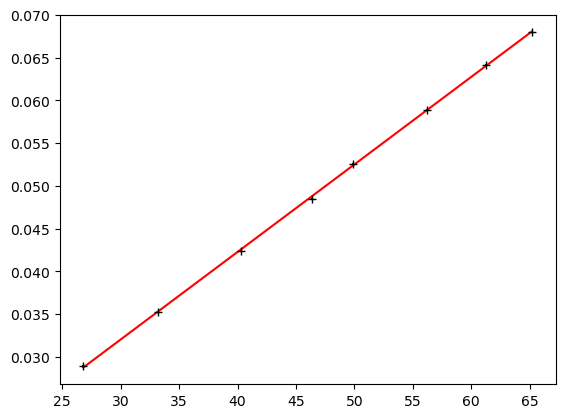

In [463]:
omega2inverse_fit = linear(out.beta, x=Ls)
plt.errorbar(Ls, omega2inverse , xerr = Ls_err, yerr= omega2inverse_err,  fmt = 'k+')
plt.plot(Ls, omega2inverse_fit, color = 'red' )


In the later part we collapse the uncertainty of $L$ onto the $\omega^2$ direction using $$ {\sigma_{y,eff}^2} = \sigma_y^2 + m^2 \sigma_x^2 $$ where $m$ is the slope, obtained from the uncertainty propagation formula


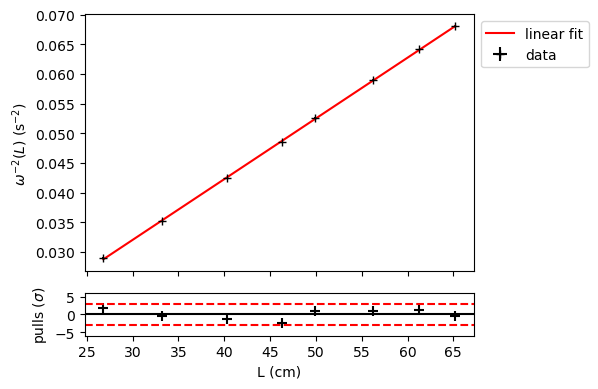

In [464]:
omega2inverse_err_effective = np.sqrt(omega2inverse_err**2 + out.beta[0]**2 * (Ls_err)**2)

pull = (omega2inverse-omega2inverse_fit)/omega2inverse_err_effective

# --- Create figure with 2 panels ---
fig, (ax_main, ax_pull) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={'height_ratios': [6, 1]},
    figsize=(6, 4)
)

# --- Top: data + fit ---
ax_main.errorbar(Ls, omega2inverse, xerr = Ls_err, yerr =omega2inverse_err , fmt='k+', label='data')
ax_main.plot(Ls, omega2inverse_fit, color='red', label= 'linear' +' '+'fit')
ax_main.set_ylabel(r"$\omega^{-2}(L)$ (s$^{-2}$)")
ax_main.legend(loc="upper left", bbox_to_anchor=(1, 1))

# --- Bottom: pulls ---
ax_pull.scatter(Ls, pull, color='black', marker="+", s=50)
ax_pull.axhline(0, color='black', linestyle='-')
ax_pull.axhline(3, color='red', linestyle='--')
ax_pull.axhline(-3, color='red', linestyle='--')
ax_pull.set_xlabel(r"L (cm)")
ax_pull.set_ylabel(r"pulls ($\sigma$)")
ax_pull.set_ylim(-6,6)

plt.tight_layout()
plt.show()

In [465]:
chi2 = np.sum(pull**2)
red_chi2 = np.sum(pull**2)/6
print(red_chi2)

2.5233332662798644
